# Heart Disease Bayesian Network Pipeline
- 数据预处理 + 连续变量离散化
- 结构学习：PC / HillClimbSearch / 自定义边
- 参数估计：MLE / Bayesian (BDeu)
- 推理：Variable Elimination & Clique Tree 示例


In [ ]:
import math
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Image, display
from pgmpy.base import DAG
from pgmpy.estimators import (
    PC,
    HillClimbSearch,
    BayesianEstimator,
    BDeu,
)
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.models import DiscreteBayesianNetwork


## Data preprocessing and discretization
- 读取 `processed.cleveland.data`，清理缺失值
- 连续特征：临床阈值分箱（默认）或分位数分箱
- 输出：原始 df 与离散化 df_disc


In [13]:
# Full column list in raw data (14 cols)
COLUMNS_ALL = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "num",
]
DROP_COLS = ["fbs", "restecg"]
COLUMNS = [c for c in COLUMNS_ALL if c not in DROP_COLS]

CONTINUOUS = ["age", "trestbps", "chol", "thalach", "oldpeak"]
CUSTOM_BINS = {
    # Clinical cutpoints from the provided risk table
    "age": [45, 60],
    "trestbps": [140],
    "chol": [200, 239],
    "thalach": [150],
    "oldpeak": [1.0],
}
RIGHT_OPEN_COLS = {"trestbps", "thalach"}  # threshold stays in upper bin (right-open)

# Full display names for plotting (avoid abbreviations)
DISPLAY_NAMES = {
    "age": "Age",
    "sex": "Sex",
    "cp": "ChestPainType",
    "trestbps": "RestingBP",
    "chol": "Cholesterol",
    "thalach": "MaxHeartRate",
    "exang": "ExerciseAngina",
    "oldpeak": "ST_Depression",
    "slope": "ST_Slope",
    "ca": "MajorVessels",
    "thal": "Thalassemia",
    "num": "Diagnosis",
}

def load_df(path: Path, has_header: bool) -> pd.DataFrame:
    return pd.read_csv(
        path,
        header=0 if has_header else None,
        names=None if has_header else COLUMNS_ALL,
        na_values="?",
    )


def bin_custom(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col, cuts in CUSTOM_BINS.items():
        edges = [-math.inf, *cuts, math.inf]
        right = col not in RIGHT_OPEN_COLS
        out[col] = pd.cut(out[col], bins=edges, labels=False, right=right)
    return out


def bin_quantile(df: pd.DataFrame, q: int) -> pd.DataFrame:
    out = df.copy()
    for col in CONTINUOUS:
        out[col] = pd.qcut(out[col], q=q, labels=False, duplicates="drop")
    return out


def preprocess_data(cfg: SimpleNamespace):
    df = load_df(Path(cfg.data), cfg.has_header)
    df = df.drop(columns=DROP_COLS)  # drop unused columns early
    if not cfg.keep_missing:
        df = df.dropna()
    df_disc = bin_custom(df) if cfg.binning == "custom" else bin_quantile(df, cfg.q)
    return df, df_disc


def plot_dag(model, outfile: str = "results/bn_pc.png", layout: str = "spring"):
    """Plot a DAG to PNG, highlighting num; labels use full names."""
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=200)

    colors = ["#e74c3c" if n == "num" else "#3498db" for n in G.nodes()]
    sizes = [1100 if n == "num" else 900 for n in G.nodes()]
    labels = {n: DISPLAY_NAMES.get(n, n) for n in G.nodes()}

    plt.figure(figsize=(9, 7), facecolor="white")
    nx.draw_networkx_nodes(
        G, pos, node_size=sizes, node_color=colors, edgecolors="#34495e", linewidths=1.5
    )
    nx.draw_networkx_labels(
        G, pos, labels=labels, font_size=10, font_weight="bold", font_color="#2c3e50"
    )
    nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=18,
        width=1.6,
        edge_color="#2c3e50",
        connectionstyle="arc3,rad=0.05",
        alpha=0.9,
    )

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(outfile, dpi=250)
    plt.close()


### Run preprocessing
可在这里修改分箱策略/分位数/缺失值策略。

In [14]:
cfg = SimpleNamespace(
    data="data/processed.cleveland.data",
    has_header=False,
    binning="custom",  # "custom" 或 "quantile"
    q=4,
    keep_missing=False,
)

df_raw, df_disc = preprocess_data(cfg)
print(f"Raw shape: {df_raw.shape}, discretized: {df_disc.shape}")
print("Unique values per column:")
print(df_disc.nunique())
df_disc.head()


Raw shape: (297, 12), discretized: (297, 12)
Unique values per column:
age         3
sex         2
cp          4
trestbps    2
chol        3
thalach     2
exang       2
oldpeak     2
slope       3
ca          4
thal        3
num         5
dtype: int64


,age,sex,cp,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,num
0,2,1.0,1.0,1,1,1,0.0,1,3.0,0.0,6.0,0
1,2,1.0,4.0,1,2,0,1.0,1,2.0,3.0,3.0,2
2,2,1.0,4.0,0,1,0,1.0,1,2.0,2.0,7.0,1
3,0,1.0,3.0,0,2,1,0.0,1,3.0,0.0,3.0,0
4,0,0.0,2.0,0,1,1,0.0,1,1.0,0.0,3.0,0


## Structure learning: PC / HillClimbSearch / Custom edges

In [15]:
def show_graphviz(model, prog: str = "dot", outfile: str = "results/bn_graphviz.png"):
    """用 pygraphviz 渲染并内联显示（标签用全名）。"""
    label_map = {n: DISPLAY_NAMES.get(n, n) for n in model.nodes()}
    try:
        g = model.to_graphviz()
    except Exception as e:
        print(f"to_graphviz failed: {e}")
        return
    try:
        for n in g.nodes():
            g.get_node(n).attr["label"] = label_map.get(n, n)
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        g.draw(outfile, prog=prog)
    except Exception as e:
        print(f"Graphviz draw failed: {e}")
        return
    display(Image(filename=outfile))


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/5 [00:00<?, ?it/s]

PC edges:
('trestbps', 'age')
('num', 'ca')
('thal', 'num')
('thal', 'sex')
('cp', 'exang')
('oldpeak', 'slope')


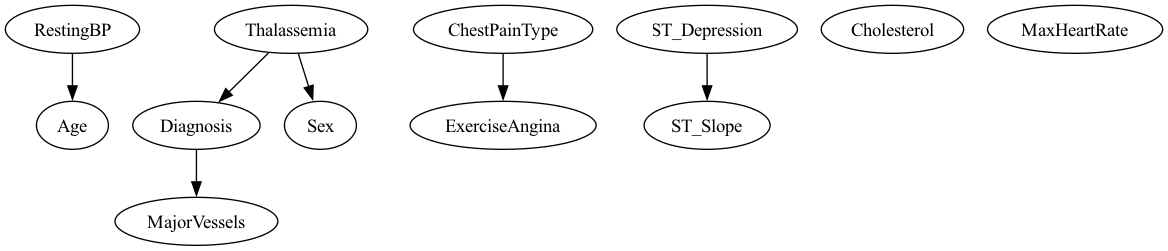

In [16]:
def learn_pc(data: pd.DataFrame, alpha: float = 0.05, max_cond_vars=None):
    pc = PC(data)
    dag: DAG = pc.estimate(
        independence_test="chi_square",
        return_type="dag",
        significance_level=alpha,
        max_cond_vars=max_cond_vars,
    )
    model = DiscreteBayesianNetwork(dag.edges())
    model.add_nodes_from(data.columns)
    return model, dag


model_pc, dag_pc = learn_pc(df_disc, alpha=0.05)
print("PC edges:")
for e in model_pc.edges():
    print(e)
show_graphviz(model_pc, outfile="results/bn_pc_graphviz.png")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

HillClimb edges (BDeu score):
('age', 'trestbps')
('sex', 'thal')
('cp', 'exang')
('exang', 'thalach')
('oldpeak', 'slope')
('oldpeak', 'exang')
('slope', 'thalach')
('ca', 'age')
('thal', 'num')
('num', 'ca')
('num', 'cp')
('num', 'oldpeak')


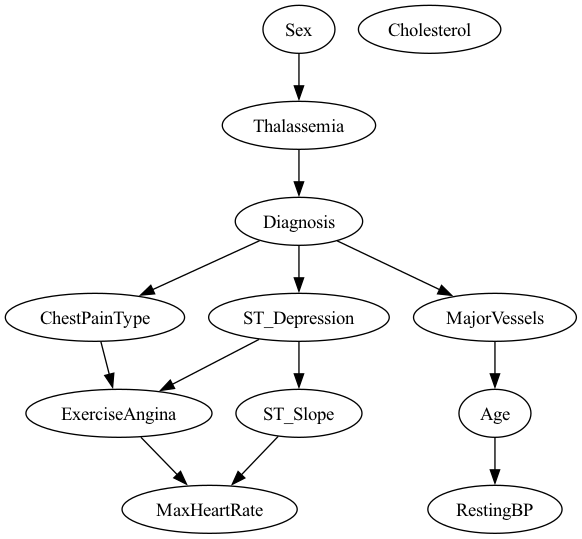

In [17]:
def learn_hc(data: pd.DataFrame, ess: int = 5):
    score = BDeu(data, equivalent_sample_size=ess)
    hc = HillClimbSearch(data)
    model = hc.estimate(scoring_method=score)
    model.add_nodes_from(data.columns)
    return model


model_hc = learn_hc(df_disc, ess=5)
print("HillClimb edges (BDeu score):")
for e in model_hc.edges():
    print(e)
show_graphviz(model_hc, outfile="results/bn_hc_graphviz.png")


Custom edges:
('age', 'trestbps')
('age', 'ca')
('age', 'chol')
('age', 'thalach')
('trestbps', 'ca')
('ca', 'num')
('chol', 'trestbps')
('chol', 'ca')
('thalach', 'exang')
('thalach', 'oldpeak')
('sex', 'chol')
('sex', 'cp')
('sex', 'thalach')
('cp', 'exang')
('cp', 'num')
('exang', 'oldpeak')
('oldpeak', 'slope')
('slope', 'num')
('thal', 'num')


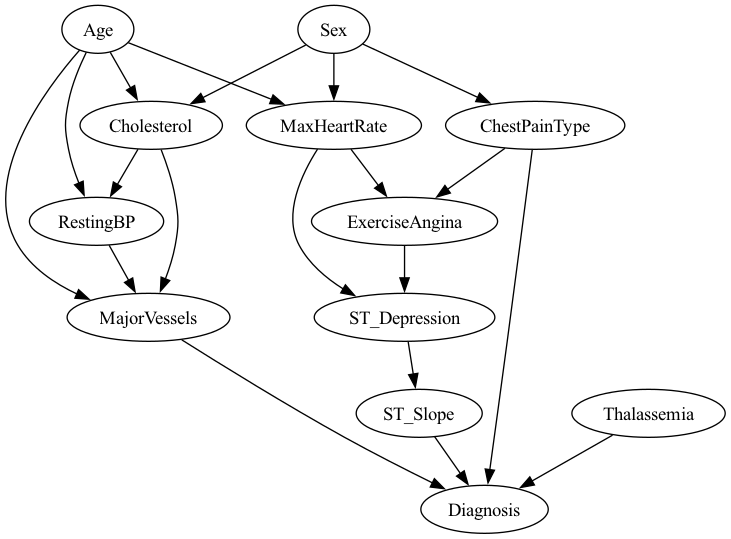

In [18]:
custom_edges = [
    # age
    ("age", "trestbps"),
    ("age", "ca"),
    ("age", "chol"),
    ("age", "thalach"),
    # sex
    ("sex", "chol"),
    ("sex", "cp"),
    ("sex", "thalach"),
    # cp
    ("cp", "exang"),
    ("cp", "num"),
    # trestbps
    ("trestbps", "ca"),
    # chol
    ("chol", "trestbps"),
    ("chol", "ca"),
    # thalach
    ("thalach", "exang"),
    ("thalach", "oldpeak"),
    # exang
    ("exang", "oldpeak"),
    # oldpeak
    ("oldpeak", "slope"),
    # slope
    ("slope", "num"),
    # ca
    ("ca", "num"),
    # thal
    ("thal", "num"),
]

model_custom = DiscreteBayesianNetwork(custom_edges)
model_custom.add_nodes_from(COLUMNS)
print("Custom edges:")
for e in model_custom.edges():
    print(e)
show_graphviz(model_custom, outfile="results/bn_custom_graphviz.png")


## Parameter estimation (CPDs)

In [19]:
def fit_with_bdeu(model_like, data: pd.DataFrame, ess: int = 5):
    edges = list(model_like.edges())
    nodes = list(model_like.nodes())
    bn = DiscreteBayesianNetwork(edges)
    bn.add_nodes_from(nodes)
    bn.fit(
        data,
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=ess,
    )
    return bn


fitted_models = {
    "pc": fit_with_bdeu(model_pc, df_disc),
    "hc": fit_with_bdeu(model_hc, df_disc),
    "custom": fit_with_bdeu(model_custom, df_disc),
}

for name, m in fitted_models.items():
    print(f"{name} model CPD count: {len(m.get_cpds())}")

print("Custom model CPD for num:")
print(fitted_models["custom"].get_cpds("num"))


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


pc model CPD count: 10
hc model CPD count: 11
custom model CPD count: 12
Custom model CPD for num:
+--------+-----------------------+-----+----------------------+
| ca     | ca(0.0)               | ... | ca(3.0)              |
+--------+-----------------------+-----+----------------------+
| cp     | cp(1.0)               | ... | cp(4.0)              |
+--------+-----------------------+-----+----------------------+
| slope  | slope(1.0)            | ... | slope(3.0)           |
+--------+-----------------------+-----+----------------------+
| thal   | thal(3.0)             | ... | thal(7.0)            |
+--------+-----------------------+-----+----------------------+
| num(0) | 0.7452667814113596    | ... | 0.006711409395973155 |
+--------+-----------------------+-----+----------------------+
| num(1) | 0.24956970740103263   | ... | 0.006711409395973155 |
+--------+-----------------------+-----+----------------------+
| num(2) | 0.0017211703958691905 | ... | 0.006711409395973155 |
+----

## Inference: Variable Elimination / Clique Tree
证据的取值需要与离散化后的取值编号一致。

In [20]:
# 确保有完整 CPD（重新拟合一次自定义结构，可改为 model_pc / model_hc）
bn_for_query = fit_with_bdeu(model_custom, df_disc, ess=5)

ve = VariableElimination(bn_for_query)
# BeliefPropagation = clique-tree based exact inference
bp = BeliefPropagation(bn_for_query)

queries = [
    {"variables": ["num"], "evidence": {"age": 2, "chol": 2, "exang": 1}},
    {"variables": ["num"], "evidence": {"cp": 3, "thal": 3}},
]

for q in queries:
    ve_res = ve.query(**q)
    bp_res = bp.query(**q)
    print("\nQuery:", q)
    print("VariableElimination:")
    print(ve_res)
    print("BeliefPropagation (Clique Tree):")
    print(bp_res)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}



Query: {'variables': ['num'], 'evidence': {'age': 2, 'chol': 2, 'exang': 1}}
VariableElimination:
+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.3226 |
+--------+------------+
| num(1) |     0.2372 |
+--------+------------+
| num(2) |     0.1583 |
+--------+------------+
| num(3) |     0.1828 |
+--------+------------+
| num(4) |     0.0991 |
+--------+------------+
BeliefPropagation (Clique Tree):
+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.3226 |
+--------+------------+
| num(1) |     0.2372 |
+--------+------------+
| num(2) |     0.1583 |
+--------+------------+
| num(3) |     0.1828 |
+--------+------------+
| num(4) |     0.0991 |
+--------+------------+

Query: {'variables': ['num'], 'evidence': {'cp': 3, 'thal': 3}}
VariableElimination:
+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.8396 |
+--------+------------+
| num(1) |     0.0932 |
+--------+----